In [ ]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import yfinance as yf # type: ignore
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from xgboost import XGBRegressor # type: ignore
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error ,mean_squared_error # type: ignore
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Baixando os preços históricos da VALE3:
df_Vale = yf.download(tickers='VALE3.SA', start='2022-01-01', end='2025-08-01', multi_level_index=False)
df_Vale = df_Vale[['Close', 'Open', 'Volume']]
df_Vale.reset_index(inplace=True)
df_Vale['Date'] = pd.to_datetime(df_Vale['Date'])
df_Vale.set_index('Date', inplace=True)
df_Vale.rename(columns={
    'Close': 'Close_VALE3',
    'Open': 'Open_VALE3',
    'Volume': 'Volume_VALE3'
}, inplace=True)

# Baixando os preços históricos do minério de ferro:
df_ferro = pd.read_csv("Dados Históricos - Minério de ferro refinado 62% Fe CFR Futuros.csv")
df_ferro.reset_index(inplace=True)
df_ferro['Data'] = pd.to_datetime(df_ferro['Data'], dayfirst=True)
df_ferro.set_index('Data', inplace=True)
df_ferro = df_ferro[['Último','Abertura', 'Var%']]
# Invertendo a ordem das datas:
df_ferro = df_ferro.sort_index(ascending=True)
df_ferro.rename(columns={
    'Último': 'Close_Ferro',
    'Abertura': 'Open_Ferro',
    'Var%': 'Variacao_ferro'
}, inplace=True) 

# Agora vamos unir os dataframes:

df = pd.merge(df_Vale, df_ferro, left_index=True, right_index=True, suffixes=('_VALE3', '_Ferro'))

# Variação percentual do preço de fechamento da VALE3:
df['Variação_VALE3'] = df_Vale['Close_VALE3'].pct_change() * 100
# Trocando nan por 0%:
df['Variação_VALE3'].fillna(0, inplace=True)

# Vamos transformar as colunas Close_Minerio, Open_Minerio e Variação_Minerio em float:
df['Close_Ferro'] = df['Close_Ferro'].str.replace(',', '.', regex=False).astype(float)
df['Open_Ferro'] = df['Open_Ferro'].str.replace(',', '.', regex=False).astype(float)
df['Variacao_ferro'] = df['Variacao_ferro'].str.replace('%', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Tratamento para transforma o index em datetime após o merge:
df.reset_index(inplace=True)
df['index'] = pd.to_datetime(df['index'], dayfirst=True)
df.rename(columns={'index': 'Data'}, inplace=True)
df.set_index('Data', inplace=True)

[*********************100%***********************]  1 of 1 completed


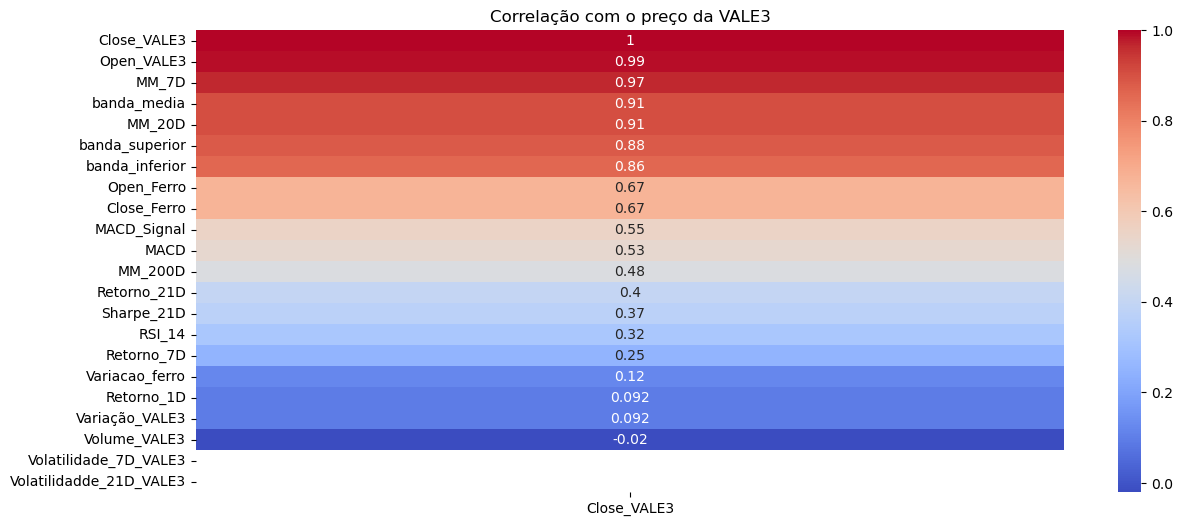

In [3]:
janelas = [7,20,200]

for janela in janelas:
    df[f'MM_{janela}D'] = df['Close_VALE3'].rolling(window=janela, min_periods=1).mean()

retornos = [1,7,21]

for retorno in retornos:
    df[f'Retorno_{retorno}D'] = df['Close_VALE3'].pct_change(retorno) * 100
    df[f'Retorno_{retorno}D'].fillna(0, inplace=True)

def calcular_RSI(series, windows=14):
    delta = series.diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_again = gain.rolling(window=windows).mean()
    avg_loss = loss.rolling(window=windows).mean()

    rs = avg_again / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df['RSI_14'] = calcular_RSI(df['Close_VALE3'], windows=14)
df['RSI_14'].fillna(df['RSI_14'].mean(), inplace=True)


MME_12 = df['Close_VALE3'].ewm(span=12, adjust=False).mean()
MME_26 = df['Close_VALE3'].ewm(span=26, adjust=False).mean()

df['MACD'] = MME_12 - MME_26

df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# primeiro pegamos as medias móveis de 20 dias:
medias_20D = df['MM_20D']
# E o desvio padrão de 20 dias também:
desvio_20D = df['Close_VALE3'].rolling(window=20, min_periods=1).std()

# Assim podemos calcular as bandas:
df['banda_media'] = medias_20D
df['banda_superior'] = medias_20D + (2 * desvio_20D)
df['banda_inferior'] = medias_20D - (2 * desvio_20D)

# Vamos completar os valores NaN com a média dos dados para cada coluna:
df['banda_inferior'].fillna(df['banda_inferior'].mean(), inplace=True)
df['banda_superior'].fillna(df['banda_superior'].mean(), inplace=True)

def Rolling_Sharpe_Ratio(returns, window=21, risk_free_rate=0.0, trading_days=252):
    # Converter taxa livre de risco para diária:
    rf_daily = (1 + risk_free_rate)**(1/trading_days) - 1

    # Calcular retornos excedentes:
    excess_return = returns - rf_daily

    # Média móvel dos retornos excedentes:
    mean_returns = excess_return.rolling(window).mean()

    # Desvio padrão móvel dos retornos excedentes:
    std_returns = excess_return.rolling(window).std()

    # Sharpe Ratio anualizado:
    sharpe_ratio = mean_returns / std_returns * np.sqrt(trading_days)

    return sharpe_ratio

# Calculando o sharpe ratio de 21 dias( 21 dias = 1 mês de trading):
df['Sharpe_21D'] = Rolling_Sharpe_Ratio(
    returns=df['Retorno_1D'],
    window=21,
    risk_free_rate= 0.15, # 15% ao ano (SELIC atual)
    trading_days=252
)

# Tratando valores NaN do sharpe de 21 dias:
df['Sharpe_21D'].fillna(0, inplace=True)
df['Sharpe_21D'].isnull().sum()

df['Volatilidade_7D_VALE3'] = np.std(df['Retorno_7D'])
df['Volatilidadde_21D_VALE3'] = np.std(df['Retorno_21D'])
df['Volatilidade_7D_VALE3'].fillna(0, inplace=True)
df['Volatilidadde_21D_VALE3'].fillna(0, inplace=True)

# Variáveis que precisam ser normalizadas:
cols_to_scale = ['Close_Ferro', 'Volume_VALE3', 'Volatilidade_7D_VALE3', 'MACD', 'Volatilidadde_21D_VALE3']

scaler = StandardScaler()

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

plt.figure(figsize=(14,6))

corr_matriz = df.corr()
sns.heatmap(corr_matriz[['Close_VALE3']].sort_values(by='Close_VALE3', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title('Correlação com o preço da VALE3')
plt.show()

features_selecionadas = df[['Close_Ferro', 'MM_200D', 'banda_superior', 'banda_inferior', 'MACD', 
                           'RSI_14', 'Retorno_21D', 'Sharpe_21D', 'Volatilidade_7D_VALE3', 'Volume_VALE3', 'Variacao_ferro']]

# preço de fechamento de 7 dias no futuro:
df['Target_7D'] = df['Close_VALE3'].shift(-7)

df.dropna(subset=['Target_7D'], inplace=True) # Eliminação dos valores NaN

# Deslocar features em 1 dia (usar dados de ontem para prever futuro):
features = [
    'Close_Ferro', 'MM_200D', 'banda_superior', 'banda_inferior', 'MACD', 
    'RSI_14', 'Retorno_21D', 'Sharpe_21D', 'Volatilidade_7D_VALE3', 
    'Volume_VALE3', 'Variacao_ferro'
]

df[features] = df[features].shift(1)
df.dropna(inplace=True)

train = df.loc['2022-01-04':'2023-12-31']
val = df.loc['2024-01-01':'2024-06-30']
test = df.loc['2024-07-01':'2025-07-22']

X_train, y_train = train.drop(columns=['Target_7D']), train['Target_7D']
X_val, y_val = val.drop(columns=['Target_7D']), val['Target_7D']
X_test, y_test = test.drop(columns=['Target_7D']), test['Target_7D']

In [4]:
df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Ferro,Open_Ferro,Variacao_ferro,Variação_VALE3,MM_7D,MM_20D,MM_200D,...,RSI_14,MACD,MACD_Signal,banda_media,banda_superior,banda_inferior,Sharpe_21D,Volatilidade_7D_VALE3,Volatilidadde_21D_VALE3,Target_7D
Data,,,,,,,,,,,,,,,,,,,,,
2022-01-04,57.085072,58.144123,-0.623531,0.388809,120.91,7.02,-1.179486,57.425745,57.425745,57.766418,...,49.600132,0.023054,-0.010870,57.425745,63.262468,55.793055,0.000000,8.881784e-16,-1.776357e-15,62.358101
2022-01-05,57.625698,57.299840,-0.652010,0.420539,124.14,0.42,0.947054,57.492396,57.492396,57.425745,...,49.600132,-0.022450,-0.019334,57.492396,58.389315,56.462175,0.000000,8.881784e-16,-1.776357e-15,62.720997
2022-01-06,58.788437,58.240398,-0.361546,0.621496,125.94,2.67,2.017744,57.816406,57.816406,57.492396,...,49.600132,-0.021477,-0.007251,57.816406,58.211800,56.772992,0.000000,8.881784e-16,-1.776357e-15,63.920746
2022-01-07,62.209988,59.543846,-0.361162,0.733484,126.21,1.45,5.820108,58.695123,58.695123,57.816406,...,49.600132,0.057447,0.071682,58.695123,59.239343,56.393469,0.000000,8.881784e-16,-1.776357e-15,65.327896
2022-01-10,61.469391,61.091686,0.629726,0.750282,124.48,0.21,-1.190479,59.157501,59.157501,58.695123,...,49.600132,0.347398,0.176399,59.157501,62.813546,54.576699,0.000000,8.881784e-16,-1.776357e-15,64.216995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-16,54.400002,54.099998,-0.136559,-1.098147,97.06,-0.27,0.908925,54.795715,53.166000,54.655440,...,65.304266,0.504243,0.377496,53.166000,56.994256,49.280744,0.892204,8.881784e-16,-1.776357e-15,55.700001
2025-07-17,54.299999,54.400002,-0.033851,-1.063306,97.18,0.58,-0.183828,54.755714,53.310500,54.648418,...,67.132878,0.477957,0.402916,53.310500,57.052611,49.279389,1.725636,8.881784e-16,-1.776357e-15,55.160000
2025-07-18,54.560001,54.049999,-0.495947,-1.055840,97.22,0.12,0.478825,54.830000,53.476500,54.640896,...,61.477042,0.445501,0.420175,53.476500,57.136646,49.484354,0.482739,8.881784e-16,-1.776357e-15,54.820000


In [6]:
df.columns

Index(['Close_VALE3', 'Open_VALE3', 'Volume_VALE3', 'Close_Ferro',
       'Open_Ferro', 'Variacao_ferro', 'Variação_VALE3', 'MM_7D', 'MM_20D',
       'MM_200D', 'Retorno_1D', 'Retorno_7D', 'Retorno_21D', 'RSI_14', 'MACD',
       'MACD_Signal', 'banda_media', 'banda_superior', 'banda_inferior',
       'Sharpe_21D', 'Volatilidade_7D_VALE3', 'Volatilidadde_21D_VALE3',
       'Target_7D'],
      dtype='object')

* Modelo SARIMA:

In [ ]:
# SARIMA com variável exógena (preço do minério de ferro):
modelo_sarima = SARIMAX(
    endog = y_train,
    exog = X_train[['Close_Ferro', 'MM_20D', 'Close_VALE3', 'Open_VALE3', 'MM_200D', 'MM_7D']],
    order = (2, 1, 2),
    seasonal_order = (1, 1, 1, 5),
    enforce_stationarity = False,
    enforce_invertibility = False
)

# Treinar o modelo:
results_sarima = modelo_sarima.fit(disp=False)

# Previsão na validação (com dados exógenos):
sarima_val_pred = results_sarima.get_forecast(
    steps=len(y_val),
    exog = X_val[['Close_Ferro', 'MM_20D', 'Close_VALE3', 'Open_VALE3', 'MM_200D', 'MM_7D']]
).predicted_mean

# Avaliação
sarima_mae = mean_absolute_error(y_val, sarima_val_pred)
print(f"SARIMA MAE: {sarima_mae:.4f}")
sarima_mape = mean_absolute_percentage_error(y_val, sarima_val_pred)
print(f"SARIMA MAPE: {sarima_mape:.4f}")

SARIMA MAE: 4.2418


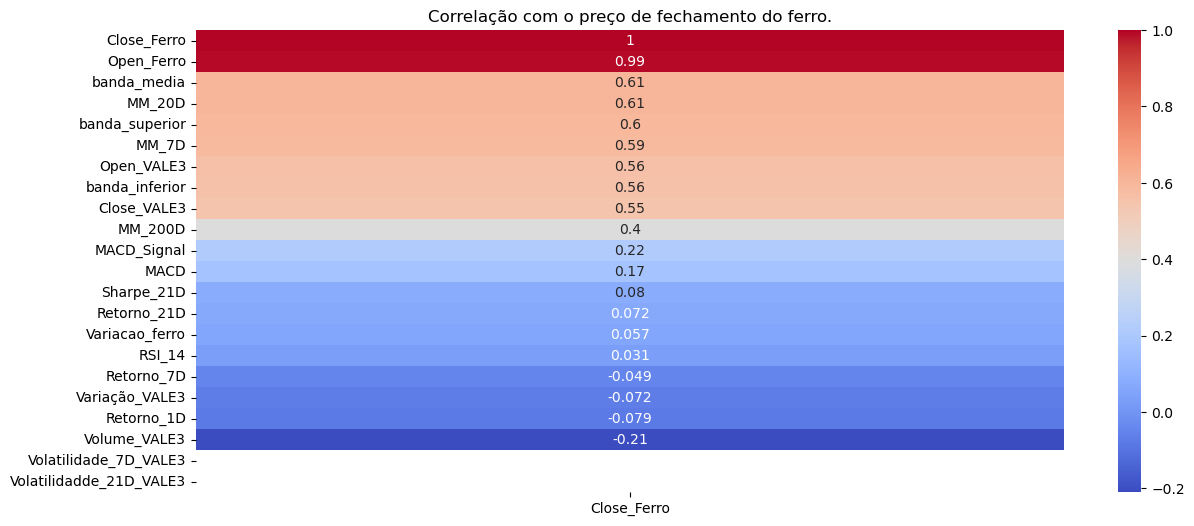

In [44]:
plt.figure(figsize=(14,6))

corr_matriz2 = X_train.corr()
sns.heatmap(corr_matriz2[['Close_Ferro']].sort_values(by='Close_Ferro', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title('Correlação com o preço de fechamento do ferro.')
plt.show()

* Modelo XGBoost:

[0]	validation_0-rmse:6.84158


[50]	validation_0-rmse:4.44472
[100]	validation_0-rmse:2.99191
[150]	validation_0-rmse:2.11123
[200]	validation_0-rmse:1.57453
[250]	validation_0-rmse:1.24345
[300]	validation_0-rmse:1.02432
[350]	validation_0-rmse:0.87849
[400]	validation_0-rmse:0.77341
[450]	validation_0-rmse:0.69059
[500]	validation_0-rmse:0.62815
[550]	validation_0-rmse:0.57274
[600]	validation_0-rmse:0.52740
[650]	validation_0-rmse:0.48665
[700]	validation_0-rmse:0.44876
[750]	validation_0-rmse:0.41575
[800]	validation_0-rmse:0.38616
[850]	validation_0-rmse:0.35845
[900]	validation_0-rmse:0.33513
[950]	validation_0-rmse:0.31369
[1000]	validation_0-rmse:0.29178
[1050]	validation_0-rmse:0.27206
[1100]	validation_0-rmse:0.25579
[1150]	validation_0-rmse:0.23836
[1200]	validation_0-rmse:0.22245
[1250]	validation_0-rmse:0.20750
[1300]	validation_0-rmse:0.19603
[1350]	validation_0-rmse:0.18362
[1400]	validation_0-rmse:0.17334
[1450]	validation_0-rmse:0.16342
[1500]	validation_0-rmse:0.15342
[1550]	validation_0-rmse:0.143

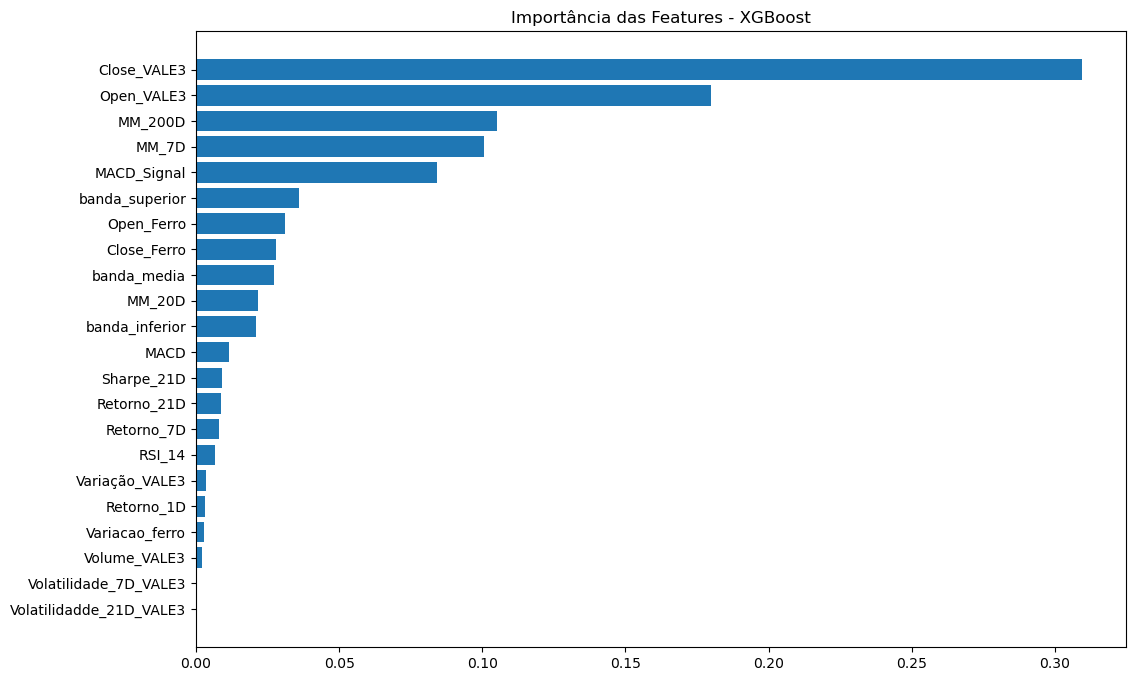

In [51]:
# Modelo XGBoost com early stopping:
modelo_xgb = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Treinamento com validação:
modelo_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)],
    verbose=50
)

# Previsão:
xgb_val_pred = modelo_xgb.predict(X_val)

# Avaliação:
xgb_mae = mean_absolute_error(y_val, xgb_val_pred)
print(f"XGBoost MAE: {xgb_mae:.4f}")
xgb_mape = mean_absolute_percentage_error(y_val, xgb_val_pred)
print(f"XGBoost MAPE: {xgb_mape:.4f}")

# Importância das features
plt.figure(figsize=(12, 8))
sorted_idx = modelo_xgb.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], modelo_xgb.feature_importances_[sorted_idx])
plt.title("Importância das Features - XGBoost")
plt.show()

* Modelo LSTM:

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 60.9515 - val_loss: 54.3633
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 57.0595 - val_loss: 50.2759
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 53.4138 - val_loss: 47.3537
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 50.3105 - val_loss: 44.6296
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 47.0179 - val_loss: 41.7122
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 44.8256 - val_loss: 38.5145
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 41.2371 - val_loss: 34.9752
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 37.5197 - val_loss: 31.2519
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 33.9921 - val_loss: 27.2701
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 29.4948 - val_loss: 23.0198
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 25.9116 - val_loss: 18.4926
Epoch 12/100
14/14 ━━━━━━━━━━

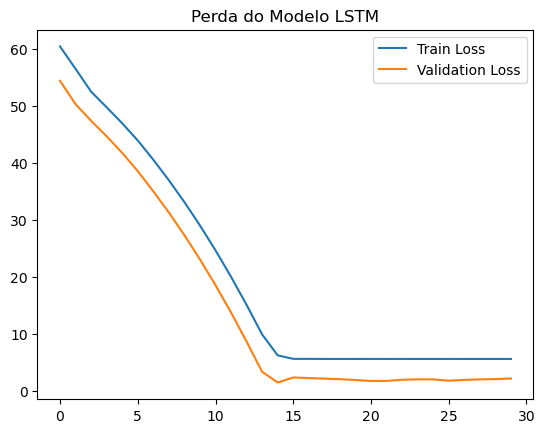

In [54]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Normalização completa:
scaller_all = StandardScaler()
X_train_scaled = scaller_all.fit_transform(X_train)
X_val_scaled = scaller_all.transform(X_val)

# Parâmetros da sequência:
window_size = 60
n_features = X_train_scaled.shape[1]

# Função para criar sequências:
def criar_sequencia(data, targets, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(targets[i])
    return np.array(X), np.array(y)

# Preparar dados sequenciais:
X_train_seq, y_train_seq =criar_sequencia(X_train_scaled, y_train.values, window_size)
X_val_seq, y_val_seq =criar_sequencia(X_val_scaled, y_val.values, window_size)

# Construir modelo LSTM
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, n_features)),
    LSTM(64, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compilar
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_absolute_error'
)

# Callback para early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Treinar
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stop],
    verbose=1
)

# Previsão
lstm_val_pred = lstm_model.predict(X_val_seq).flatten()

# Avaliação
lstm_mae = mean_absolute_error(y_val[window_size:], lstm_val_pred)
print(f"LSTM MAE: {lstm_mae:.4f}")

# Plot de perda
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Perda do Modelo LSTM')
plt.show()


In [55]:
lstm_mape = mean_absolute_percentage_error(y_val[window_size:], lstm_val_pred)
print(f"LSTM MAPE: {lstm_mape:.4f}")

LSTM MAPE: 0.0246
